In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
#import tensorflow as tf
import holidays
import os
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense , LSTM
#from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

In [305]:
store_sales = pd.read_csv("/Users/hhamidizadeh/ReorderingSystem/INVENTORY-DEMAND-FORCASTING/4999122.csv")
store_sales

,Unnamed: 0,Planned dates,MRP element,MRP elmnt data,Rescheduling date,Exception,Rec./reqd qty,Avail. Quantity,Plng Plant,Stor. Loc.,Rec P. Qty,Day of the Week
0,NaN,11/26/2024,Stock,"On-Hold: 263,232.000 M",NaN,82.0,0.000,"394,848",NaN,NaN,NaN,Tuesday
1,NaN,11/26/2024,SafeSt,Safety Stock,NaN,NaN,"-1,579,392","-1,184,544",NaN,NaN,1579.39-,Tuesday
2,NaN,10/30/2024,PO,4500196146/00010,NaN,10.0,"789,696","-394,848",NaN,2000.0,789.70,Wednesday
3,NaN,11/27/2024,PO,4500202241/00010,11/26/2024,10.0,"394,848",0,NaN,2000.0,394.85,Wednesday
4,NaN,11/29/2024,Transf,0225098183/00010,NaN,NaN,"-43,872","-43,872",ORM2,2000.0,43.87-,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
467,NaN,12/4/2025,Transf,0225098447/00010,NaN,NaN,"-394,848","1,864,560",CRE1,2000.0,394.85-,Thursday
468,NaN,12/4/2025,Transf,0225099095/00010,NaN,NaN,"-98,712","1,765,848",ORM1,2000.0,98.71-,Thursday
469,NaN,12/4/2025,Transf,0225165809/00010,NaN,NaN,"-109,680","1,656,168",LAN1,2000.0,109.68-,Thursday
470,NaN,12/4/2025,Transf,0225165828/00010,NaN,NaN,"-252,264","1,403,904",LOC1,2000.0,252.26-,Thursday


In [306]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         0 non-null      float64
 1   Planned dates      472 non-null    object 
 2   MRP element        472 non-null    object 
 3   MRP elmnt data     472 non-null    object 
 4   Rescheduling date  4 non-null      object 
 5   Exception          6 non-null      float64
 6   Rec./reqd qty      472 non-null    object 
 7   Avail. Quantity    472 non-null    object 
 8   Plng Plant         417 non-null    object 
 9   Stor. Loc.         470 non-null    float64
 10  Rec P. Qty         471 non-null    object 
 11  Day of the Week    472 non-null    object 
dtypes: float64(3), object(9)
memory usage: 44.4+ KB


**Check for Missing Values:**

In [307]:
store_sales.isnull().sum()


Unnamed: 0           472
Planned dates          0
MRP element            0
MRP elmnt data         0
Rescheduling date    468
Exception            466
Rec./reqd qty          0
Avail. Quantity        0
Plng Plant            55
Stor. Loc.             2
Rec P. Qty             1
Day of the Week        0
dtype: int64

**Data Preprocessing**

In [308]:
# Filter rows where 'Plng Plant' equals 'PlantA'
store_sales = store_sales[store_sales['MRP element'] == 'Transf']
store_sales = store_sales.drop(columns=['MRP element','MRP elmnt data','Rescheduling date','Exception','Plng Plant','Stor. Loc.','Rec P. Qty','Day of the Week'],axis=1) #Dropping store and items columns



In [309]:
store_sales['Planned dates'] = pd.to_datetime (store_sales['Planned dates']) #converting date from object datatype to date Time datatype
store_sales['Rec./reqd qty'] = store_sales['Rec./reqd qty'].str.replace(',', '').astype(float)
store_sales['Avail. Quantity'] = store_sales['Avail. Quantity'].str.replace(',', '').astype(float)

In [310]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417 entries, 4 to 471
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       0 non-null      float64       
 1   Planned dates    417 non-null    datetime64[ns]
 2   Rec./reqd qty    417 non-null    float64       
 3   Avail. Quantity  417 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 16.3 KB


In [311]:
#store_sales['Planned dates'] = store_sales['Planned dates'].dt.to_period('M') #converting date to a Month period, and then sum the nmber of items in each month
#monthly_sales = store_sales.groupby('Planned dates').sum().reset_index()
store_sales['Planned dates'] = pd.to_datetime(store_sales['Planned dates'])  # Ensure 'Planned dates' is datetime

# Group by biweekly periods
biweekly_sales = store_sales.groupby(pd.Grouper(key='Planned dates', freq='W')).sum().reset_index()

# Display the biweekly sales
print(biweekly_sales.head())
print(biweekly_sales['Planned dates'].dtype)


  Planned dates  Unnamed: 0  Rec./reqd qty  Avail. Quantity
0    2024-12-01         0.0       -87744.0        -263232.0
1    2024-12-08         0.0      -658080.0        7918896.0
2    2024-12-15         0.0      -449688.0        2500704.0
3    2024-12-22         0.0      -965184.0        7677600.0
4    2024-12-29         0.0       -43872.0         954216.0
datetime64[ns]


In [312]:
#monthly_sales['Planned dates'] = monthly_sales['Planned dates'].dt.to_timestamp() #convert the resulting date column to timestamp datatype
#biweekly_sales['Planned dates'] = biweekly_sales['Planned dates'].dt.to_timestamp() #convert the resulting date column to timestamp datatype


In [313]:
#monthly_sales.head (10)
biweekly_sales.head(10)
biweekly_sales

,Planned dates,Unnamed: 0,Rec./reqd qty,Avail. Quantity
0,2024-12-01,0.0,-87744.0,-263232.0
1,2024-12-08,0.0,-658080.0,7918896.0
2,2024-12-15,0.0,-449688.0,2500704.0
3,2024-12-22,0.0,-965184.0,7677600.0
4,2024-12-29,0.0,-43872.0,954216.0
5,2025-01-05,0.0,-383880.0,2829744.0
6,2025-01-12,0.0,-1403904.0,11779632.0
7,2025-01-19,0.0,-1502616.0,12887400.0
8,2025-01-26,0.0,-1305192.0,11702856.0
9,2025-02-02,0.0,-1392936.0,10342824.0


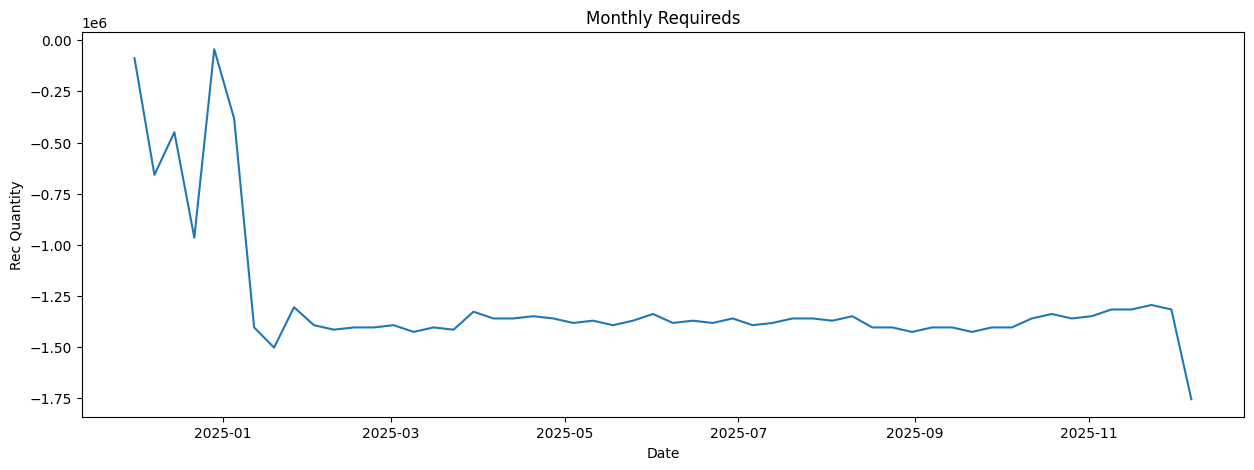

In [314]:
plt.figure(figsize=(15,5)) #Visualization
plt.plot(biweekly_sales['Planned dates'],biweekly_sales['Rec./reqd qty'])
plt.xlabel("Date")
plt.ylabel("Rec Quantity")
plt.title("Monthly Requireds")
plt.show()

In [315]:
biweekly_sales['req_diff'] = biweekly_sales['Rec./reqd qty'].diff() #call the difference on the sales columns to make the sales data stationery
biweekly_sales = biweekly_sales.dropna ()
biweekly_sales.head (10)
biweekly_sales

,Planned dates,Unnamed: 0,Rec./reqd qty,Avail. Quantity,req_diff
1,2024-12-08,0.0,-658080.0,7918896.0,-570336.0
2,2024-12-15,0.0,-449688.0,2500704.0,208392.0
3,2024-12-22,0.0,-965184.0,7677600.0,-515496.0
4,2024-12-29,0.0,-43872.0,954216.0,921312.0
5,2025-01-05,0.0,-383880.0,2829744.0,-340008.0
6,2025-01-12,0.0,-1403904.0,11779632.0,-1020024.0
7,2025-01-19,0.0,-1502616.0,12887400.0,-98712.0
8,2025-01-26,0.0,-1305192.0,11702856.0,197424.0
9,2025-02-02,0.0,-1392936.0,10342824.0,-87744.0
10,2025-02-09,0.0,-1414872.0,12898368.0,-21936.0


In [316]:
supervised_data = biweekly_sales.drop(['Planned dates', 'Rec./reqd qty'], axis=1) #Dropping off sales and date
supervised_data

,Unnamed: 0,Avail. Quantity,req_diff
1,0.0,7918896.0,-570336.0
2,0.0,2500704.0,208392.0
3,0.0,7677600.0,-515496.0
4,0.0,954216.0,921312.0
5,0.0,2829744.0,-340008.0
6,0.0,11779632.0,-1020024.0
7,0.0,12887400.0,-98712.0
8,0.0,11702856.0,197424.0
9,0.0,10342824.0,-87744.0
10,0.0,12898368.0,-21936.0


In [317]:
for i in range(1,13): #preparing the supervised data
  col_name = 'biweek_' + str(i)
  supervised_data[col_name] = supervised_data['req_diff'].shift(i)
supervised_data = supervised_data.dropna()
supervised_data.head()

,Unnamed: 0,Avail. Quantity,req_diff,biweek_1,biweek_2,biweek_3,biweek_4,biweek_5,biweek_6,biweek_7,biweek_8,biweek_9,biweek_10,biweek_11,biweek_12
13,0.0,12130608.0,10968.0,0.0,10968.0,-21936.0,-87744.0,197424.0,-98712.0,-1020024.0,-340008.0,921312.0,-515496.0,208392.0,-570336.0
14,0.0,11658984.0,-32904.0,10968.0,0.0,10968.0,-21936.0,-87744.0,197424.0,-98712.0,-1020024.0,-340008.0,921312.0,-515496.0,208392.0
15,0.0,13512576.0,21936.0,-32904.0,10968.0,0.0,10968.0,-21936.0,-87744.0,197424.0,-98712.0,-1020024.0,-340008.0,921312.0,-515496.0
16,0.0,10913160.0,-10968.0,21936.0,-32904.0,10968.0,0.0,10968.0,-21936.0,-87744.0,197424.0,-98712.0,-1020024.0,-340008.0,921312.0
17,0.0,13896456.0,87744.0,-10968.0,21936.0,-32904.0,10968.0,0.0,10968.0,-21936.0,-87744.0,197424.0,-98712.0,-1020024.0,-340008.0


In [318]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (29, 15)
Test Data Shape:  (12, 15)


In [319]:
scaler = MinMaxScaler (feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [320]:
X_train, y_train= train_data[:,1:], train_data[:,0:1]
X_test, y_test=test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test= y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (29, 14)
y_train Shape:  (29,)
X_test Shape:  (12, 14)
y_test Shape:  (12,)


In [321]:
sales_dates = biweekly_sales['Planned dates'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [322]:
act_sales = biweekly_sales['Rec./reqd qty'][-13:].to_list()
print(act_sales)

[-1403904.0, -1425840.0, -1403904.0, -1403904.0, -1360032.0, -1338096.0, -1360032.0, -1349064.0, -1316160.0, -1316160.0, -1294224.0, -1316160.0, -1754880.0]


In [323]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre=lr_model.predict(X_test)

In [324]:
lr_pre =lr_pre.reshape(-1,1)
# This is a set matrix - contains the input features of the test data, and also the predicted output
lr_pre_test_set = np.concatenate ([lr_pre, X_test], axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)

In [325]:
result_list =[]
for index in range(0, len(lr_pre_test_set)):
   result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd. Series (result_list, name="Linear Prediction")
predict_df = predict_df.merge (lr_pre_series, left_index = True, right_index= True)
print(predict_df.columns)
print(biweekly_sales.columns)

Index(['Planned dates', 'Linear Prediction'], dtype='object')
Index(['Planned dates', 'Unnamed: 0', 'Rec./reqd qty', 'Avail. Quantity',
       'req_diff'],
      dtype='object')


In [326]:
# print(predict_df)
historical_predictions = predict_df['Linear Prediction'][-12:]  # Last 12 predictions
actual_sales = biweekly_sales['Rec./reqd qty'][-12:]  # Last 12 actual sales data

# Ensure you only compare the historical data and exclude future predictions
lr_mse = np.sqrt(mean_squared_error(historical_predictions, actual_sales))
lr_mae = mean_absolute_error(historical_predictions, actual_sales)
lr_r2 = r2_score(historical_predictions, actual_sales)

print("Linear Regression MSE: ", lr_mse )
print("Linear Regression MAE: ", lr_mae )
print("Linear Regression R2: ", lr_r2 )
biweekly_sales


Linear Regression MSE:  128611.20013435844
Linear Regression MAE:  54840.0
Linear Regression R2:  -8.57910014513788


,Planned dates,Unnamed: 0,Rec./reqd qty,Avail. Quantity,req_diff
1,2024-12-08,0.0,-658080.0,7918896.0,-570336.0
2,2024-12-15,0.0,-449688.0,2500704.0,208392.0
3,2024-12-22,0.0,-965184.0,7677600.0,-515496.0
4,2024-12-29,0.0,-43872.0,954216.0,921312.0
5,2025-01-05,0.0,-383880.0,2829744.0,-340008.0
6,2025-01-12,0.0,-1403904.0,11779632.0,-1020024.0
7,2025-01-19,0.0,-1502616.0,12887400.0,-98712.0
8,2025-01-26,0.0,-1305192.0,11702856.0,197424.0
9,2025-02-02,0.0,-1392936.0,10342824.0,-87744.0
10,2025-02-09,0.0,-1414872.0,12898368.0,-21936.0


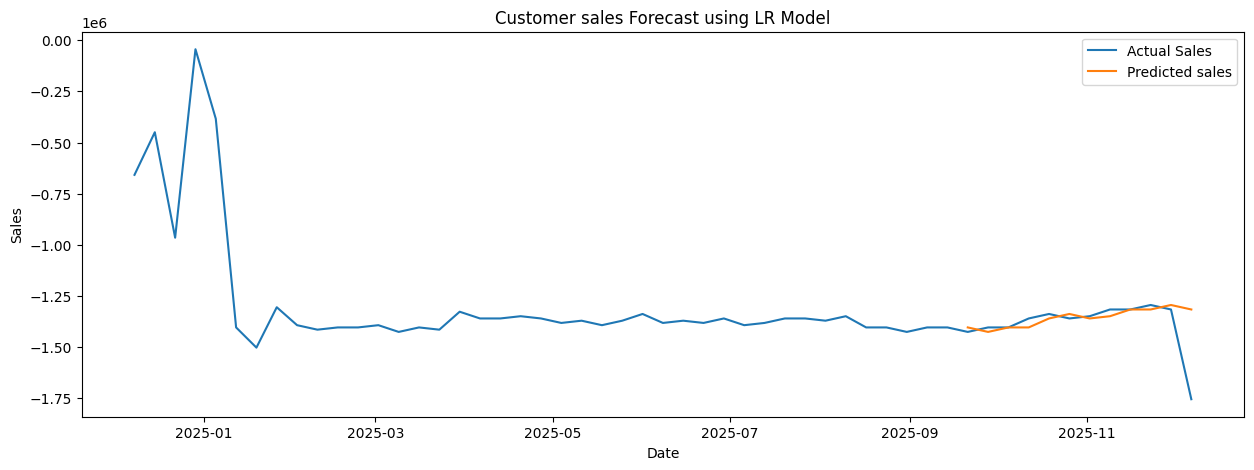

In [327]:
plt.figure(figsize=(15,5))
# Actual sales
plt.plot(biweekly_sales['Planned dates'], biweekly_sales['Rec./reqd qty'])
# Predicted sales
plt.plot(predict_df['Planned dates'], predict_df['Linear Prediction'])
plt.title("Customer sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend (['Actual Sales', 'Predicted sales'])
plt.show()

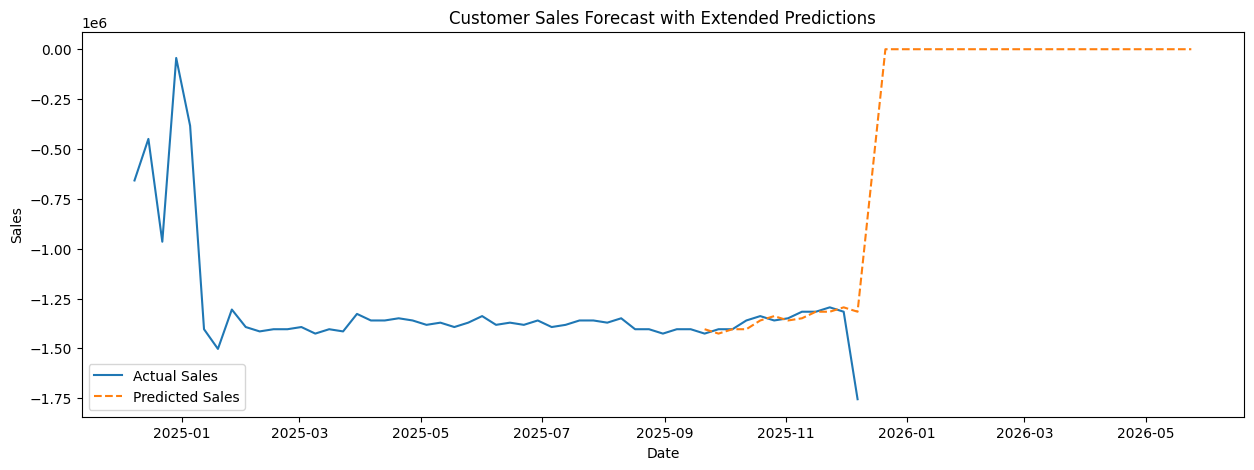

In [328]:
# Generate future dates
future_periods = 12  # Number of biweekly periods to predict into the future
last_date = biweekly_sales['Planned dates'].iloc[-1]
future_dates = [last_date + pd.Timedelta(weeks=2 * i) for i in range(1, future_periods + 1)]
future_dates_df = pd.DataFrame(future_dates, columns=['Planned dates'])

# Initialize predictions list
extended_predictions = []

# Start with the last known features
last_known_features = X_test[-1, :].reshape(1, -1)

# Iteratively predict future values using the model
for _ in range(future_periods):
    next_prediction = lr_model.predict(last_known_features)[0]  # Predict the next value
    extended_predictions.append(next_prediction)
    
    # Update lag features: shift existing features and add the new prediction
    new_features = np.roll(last_known_features, shift=-1, axis=1)  # Shift features to the left
    new_features[0, -1] = next_prediction  # Insert the new prediction as the latest lag
    last_known_features = new_features

# Inverse transform the extended predictions to their original scale
extended_predictions = np.array(extended_predictions).reshape(-1, 1)
extended_features = np.concatenate([extended_predictions, np.zeros((future_periods, X_test.shape[1]))], axis=1)
extended_features = scaler.inverse_transform(extended_features)

# Extract only the predicted values
future_sales_predictions = extended_features[:, 0]

# Combine the results with existing predictions
predict_df = pd.concat([
    predict_df,
    pd.DataFrame({'Planned dates': future_dates, 'Linear Prediction': future_sales_predictions})
], ignore_index=True)

# Plot updated results
plt.figure(figsize=(15, 5))
plt.plot(biweekly_sales['Planned dates'], biweekly_sales['Rec./reqd qty'], label='Actual Sales')
plt.plot(predict_df['Planned dates'], predict_df['Linear Prediction'], label='Predicted Sales', linestyle='--')
plt.title("Customer Sales Forecast with Extended Predictions")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()
